# Most Reliable Path

Most Reliable Path (MRP) is a variant of the Shortest Path Problem, where, each edge is
randomly associated with probabilities (0.512 or 0.8) which denotes the “reliability” of the edge,
and the task is to find the most reliable path between the source and the destination node. We
do not remove edges this time.

We use the same 5-layer MLP in the SP experiment as the baseline. We also use the simplepath and the reachability constraints to train the neural network by DeepLPMLN. Besides, we
use weak constraints to represent the probability of each edge in the grid.

## Data Format

In dataGen.py, a class named "GridProbData" is defined in the following way.

GridProbData class has 6 attributes: train_data, test_data, valid_data, train_labels, test_labels, valid_labels.

train_data is an numpy array of size (1800, 40). It consists of 1800 data as follows 

        [  
          data,  
          ...,  
          data  
        ]  

where data is a vector (numpy array) of length 40. For example, the data shown below  

        [  
          0.512 0.8 0.512 0.8 0.512  
          0.512 0.8 0.512 0.512 0.8  
          0.8 0.512 0.512 0.8 0.512  
          0.512 0.512 0.512 0.512 0.8  
          0.512 0.8 0.512 0.8  
          10000 00000 01000 0  
        ]  

defines the 24 probabilities of the 24 edges and specified that the nodes 0 and 11 are the starting and ending nodes.  
train_labels is an numpy array of size (1800, 24). It consists of 1800 label as follows.  

        [  
          label,  
          ...,  
          label  
        ]  

where label is a vector (numpy array) of length 24. For example, the label shown below  

        [11100 00000 00000 00000 0110]  

means that the edges 0, 1, 2, 21, 22 form a most reliable path.  
test_data is a numpy array of size (600, 40).  
valid_data is a numpy array of size (600, 40).  
test_labels is a numpy array of size (600, 24).  
valid_labels is a numpy array of size (600, 24).  



## Imports

In [1]:
import sys
sys.path.append("../../")
import random
import time

import numpy as np
import torch
from torch.autograd import Variable

from dataGen import GridProbData
from dlpmln import DeepLPMLN
from network import FC

In [2]:

import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

from dlpmln import DeepLPMLN


## DeepLPMLN Programs for Training and Testing

In [3]:
dprogram = '''
grid(g).
nn(m(g,24), nn_edge, [t,f]) :- grid(g).
sp(0,1) :- nn_edge(g, 0, t).
sp(1,2) :- nn_edge(g, 1, t).
sp(2,3) :- nn_edge(g, 2, t).
sp(4,5) :- nn_edge(g, 3, t).
sp(5,6) :- nn_edge(g, 4, t).
sp(6,7) :- nn_edge(g, 5, t).
sp(8,9) :- nn_edge(g, 6, t).
sp(9,10) :- nn_edge(g, 7, t).
sp(10,11) :- nn_edge(g, 8, t).
sp(12,13) :- nn_edge(g, 9, t).
sp(13,14) :- nn_edge(g, 10, t).
sp(14,15) :- nn_edge(g, 11, t).
sp(0,4) :- nn_edge(g, 12, t).
sp(4,8) :- nn_edge(g, 13, t).
sp(8,12) :- nn_edge(g, 14, t).
sp(1,5) :- nn_edge(g, 15, t).
sp(5,9) :- nn_edge(g, 16, t).
sp(9,13) :- nn_edge(g, 17, t).
sp(2,6) :- nn_edge(g, 18, t).
sp(6,10) :- nn_edge(g, 19, t).
sp(10,14) :- nn_edge(g, 20, t).
sp(3,7) :- nn_edge(g, 21, t).
sp(7,11) :- nn_edge(g, 22, t).
sp(11,15) :- nn_edge(g, 23, t).
sp(X,Y) :- sp(Y,X).
mistake :- X=0..15, #count{Y: sp(X,Y)} = 1.
mistake :- X=0..15, #count{Y: sp(X,Y)} >= 3.
reachable(X, Y) :- sp(X, Y).
reachable(X, Y) :- reachable(X, Z), sp(Z, Y).
mistake :- sp(X, _), sp(Y, _), not reachable(X, Y).
'''

dprogram_test = '''
grid(g).
sp(0,1) :- nn_edge(g, 0, t).
sp(1,2) :- nn_edge(g, 1, t).
sp(2,3) :- nn_edge(g, 2, t).
sp(4,5) :- nn_edge(g, 3, t).
sp(5,6) :- nn_edge(g, 4, t).
sp(6,7) :- nn_edge(g, 5, t).
sp(8,9) :- nn_edge(g, 6, t).
sp(9,10) :- nn_edge(g, 7, t).
sp(10,11) :- nn_edge(g, 8, t).
sp(12,13) :- nn_edge(g, 9, t).
sp(13,14) :- nn_edge(g, 10, t).
sp(14,15) :- nn_edge(g, 11, t).
sp(0,4) :- nn_edge(g, 12, t).
sp(4,8) :- nn_edge(g, 13, t).
sp(8,12) :- nn_edge(g, 14, t).
sp(1,5) :- nn_edge(g, 15, t).
sp(5,9) :- nn_edge(g, 16, t).
sp(9,13) :- nn_edge(g, 17, t).
sp(2,6) :- nn_edge(g, 18, t).
sp(6,10) :- nn_edge(g, 19, t).
sp(10,14) :- nn_edge(g, 20, t).
sp(3,7) :- nn_edge(g, 21, t).
sp(7,11) :- nn_edge(g, 22, t).
sp(11,15) :- nn_edge(g, 23, t).
sp(X,Y) :- sp(Y,X).
mistake :- X=0..15, #count{Y: sp(X,Y)} = 1.
mistake :- X=0..15, #count{Y: sp(X,Y)} >= 3.
reachable(X, Y) :- sp(X, Y).
reachable(X, Y) :- reachable(X, Z), sp(Z, Y).
mistake :- sp(X, _), sp(Y, _), not reachable(X, Y).
'''

## Neural Network Instantiation
- Instantiate neural networks.
- Define nnMapping: a dictionary that maps neural network names (i.e., strings) to the neural network objects (i.e., torch.nn.Module object)
- Define optimizers: a dictionary that specifies the optimizer for each network (we use the Adam optimizer here).

In [4]:
m = FC(40, 50, 50, 50, 50, 50, 24)
nnMapping = {'m': m}
optimizers = {'m':torch.optim.Adam(m.parameters(), lr=0.001)}

Neural Network (MLP) Structure: (40, 50, 50, 50, 50, 50, 24)


## Create DeepLPMLN object

In [5]:
dlpmlnObj = DeepLPMLN(dprogram, nnMapping, optimizers)

## Create dataList and obsList for Training, testDataList and testObsList for Testing
### Create the dataset object

In [6]:
dataset = GridProbData("data/data.txt")

there are 3000 data in total, 60% training data, 20% validation data, 20% testing data!


### Construct dataList and obsList

In [7]:
dataList = []
obsList = []
for i, d in enumerate(dataset.train_data):
    d_tensor = Variable(torch.from_numpy(d).float(), requires_grad=False)
    dataList.append({"g": d_tensor})
 
with open("data/evidence_train.txt", 'r') as f:
    obsList = f.read().strip().strip("#evidence").split("#evidence")

### Construct testDataList and testObsList

In [8]:
testDataList = []
testObsList = []

for d in dataset.test_data:
    d_tensor = Variable(torch.from_numpy(d).float(), requires_grad=False)
    testDataList.append({"g": d_tensor})

with open("data/evidence_test.txt", 'r') as f:
    testObsList = f.read().strip().strip("#evidence").split("#evidence")

## Training and Testing

Note that our target is to find the path with the highest probability, which is represented by the optimal stable models of the logic program. To find the optimal stable models instead of stable models during training, we need to specify "opt=True" in the learning function.

In [9]:
for i in range(200):
    print('Epoch {}...'.format(i+1))
	dlpmlnObj.learn(dataList, obsList, epoch=1, opt=True, storeSM=True)
	dlpmlnObj.testConstraint(testDataList, testObsList,[dprogram_test])

The accuracy for constraint 1 is 0.0
The accuracy for constraint 1 is 0.005
The accuracy for constraint 1 is 0.03166666666666667
The accuracy for constraint 1 is 0.10833333333333334
The accuracy for constraint 1 is 0.16833333333333333
The accuracy for constraint 1 is 0.26
The accuracy for constraint 1 is 0.29
The accuracy for constraint 1 is 0.28833333333333333
The accuracy for constraint 1 is 0.325
The accuracy for constraint 1 is 0.335
The accuracy for constraint 1 is 0.38333333333333336
The accuracy for constraint 1 is 0.38
The accuracy for constraint 1 is 0.43666666666666665
The accuracy for constraint 1 is 0.5016666666666667
The accuracy for constraint 1 is 0.505
The accuracy for constraint 1 is 0.495
The accuracy for constraint 1 is 0.455
The accuracy for constraint 1 is 0.5333333333333333
The accuracy for constraint 1 is 0.5166666666666667
The accuracy for constraint 1 is 0.505
The accuracy for constraint 1 is 0.495
The accuracy for constraint 1 is 0.5133333333333333
The accurac

The accuracy for constraint 1 is 0.75
The accuracy for constraint 1 is 0.72
The accuracy for constraint 1 is 0.7316666666666667
The accuracy for constraint 1 is 0.7316666666666667
The accuracy for constraint 1 is 0.7266666666666667
The accuracy for constraint 1 is 0.76
The accuracy for constraint 1 is 0.7183333333333334
The accuracy for constraint 1 is 0.745
The accuracy for constraint 1 is 0.7483333333333333
The accuracy for constraint 1 is 0.7133333333333334
The accuracy for constraint 1 is 0.73
The accuracy for constraint 1 is 0.7383333333333333
The accuracy for constraint 1 is 0.7433333333333333
The accuracy for constraint 1 is 0.7166666666666667
The accuracy for constraint 1 is 0.7033333333333334
The accuracy for constraint 1 is 0.715
The accuracy for constraint 1 is 0.7216666666666667
The accuracy for constraint 1 is 0.7316666666666667
The accuracy for constraint 1 is 0.7716666666666666
The accuracy for constraint 1 is 0.7583333333333333
The accuracy for constraint 1 is 0.775
The

## Comparison

The following table compares the different accuracies on the test data between MLP Only
trained by cross entropy loss and the same MLP trained by DeepLPMLN. 

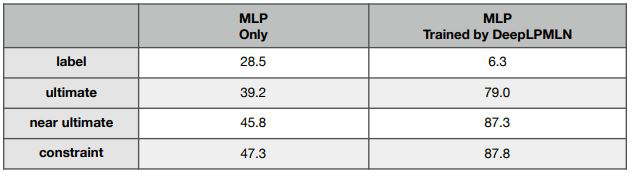

In [10]:
from IPython.display import display
from PIL import Image

path="accuracy_comparison.jpg"
display(Image.open(path))

In the above table, the label accuracy is the measure against the label for which the neural
network is trained for. Note that the MRP problem (and the SP and the top K in the next
section) are not “functional” problems in the sense that there may be multiple solutions
possible. In such a case, we select only one among them as the label in the training set to be in
favor of neural network learning.

However, it is possible that the prediction different from the label is still correct. To account for
this, we consider the ultimate accuracy, which counts such prediction correct. The near
ultimate accuracy is similar but a bit more relaxed. It allows more predictions to be correct by
including near optimal paths in which the number of edges is the same as that of a most
reliable path but a 0.512 edge is contained instead of a 0.8 edge.

The constraint accuracy counts if the prediction satisfies the simple-path and the reachability
constraints regardless whether it’s most reliable or not.
